# EDA 02 — Univariate analysis (label-aware plots)

This notebook performs a simple, label-aware univariate EDA:
- Explicitly define descriptor (feature) columns vs label/meta columns
- Plot histograms and boxplots by label (hue)
- Export a clean feature list for downstream consistency

Outputs:
- Figures: `results/eda/figures/univariate/`
- Tables: `results/eda/stats/`


In [15]:
from __future__ import annotations

from pathlib import Path
from typing import List, Optional

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# -------------------------
# Plot style
# -------------------------
sns.set_context("notebook")
sns.set_style("whitegrid")

plt.rcParams["figure.dpi"] = 140
plt.rcParams["savefig.dpi"] = 300

# -------------------------
# Paths
# -------------------------
PROJECT_ROOT = Path("../../").resolve()

DATA_PROCESSED_DIR = PROJECT_ROOT / "data" / "processed_variants"
STRICT_CSV  = DATA_PROCESSED_DIR / "hcs_strict_complete_case_20260129_114259.csv"
IMPUTED_CSV = DATA_PROCESSED_DIR / "hcs_imputed_exploratory_20260129_114259.csv"

EDA_ROOT = PROJECT_ROOT / "results" / "eda"
FIG_DIR = EDA_ROOT / "figures" / "univariate"
STATS_DIR = EDA_ROOT / "stats"

FIG_DIR.mkdir(parents=True, exist_ok=True)
STATS_DIR.mkdir(parents=True, exist_ok=True)

print("DATA_PROCESSED_DIR:", DATA_PROCESSED_DIR)
print("FIG_DIR:", FIG_DIR)
print("STATS_DIR:", STATS_DIR)


DATA_PROCESSED_DIR: /home/david/Desktop/colabs/serra_ramon/hypercholesterolemia_classifiers/data/processed_variants
FIG_DIR: /home/david/Desktop/colabs/serra_ramon/hypercholesterolemia_classifiers/results/eda/figures/univariate
STATS_DIR: /home/david/Desktop/colabs/serra_ramon/hypercholesterolemia_classifiers/results/eda/stats


In [17]:
def load_dataset(path: Path) -> pd.DataFrame:
    """
    Load a dataset from disk (CSV).

    Parameters
    ----------
    path : Path
        Path to the CSV file.

    Returns
    -------
    pd.DataFrame
        Loaded dataframe.

    Raises
    ------
    FileNotFoundError
        If the file does not exist.
    """
    if not path.exists():
        raise FileNotFoundError(f"Dataset not found: {path}")
    return pd.read_csv(path)

df_strict = load_dataset(STRICT_CSV)
df_imputed = load_dataset(IMPUTED_CSV)

print("STRICT:", df_strict.shape)
print("IMPUTED:", df_imputed.shape)

display(df_strict.head(3))


STRICT: (148, 15)
IMPUTED: (160, 15)


,row_id,_sheet,LocalID,Age,Weight,Height,BMI_final,Glycemia,SBP_1T,DBP_1T,TC_1T,TG_1T,HDL_1T,LDL_1T,MSPH
0,cohorte_and_000000,cohorte_and,1,33,68.0,169.0,23.8,76.2,101.0,60.0,239,85.1,69.0,153.0,1
1,cohorte_and_000001,cohorte_and,2,37,58.8,162.0,22.4,71.9,101.0,58.0,222,97.0,65.6,137.0,1
2,cohorte_and_000002,cohorte_and,3,30,63.0,160.0,24.6,79.8,113.0,58.0,197,100.0,56.3,120.7,1


In [18]:
# ============================================================
# EXPLICIT COLUMN DEFINITIONS
# ============================================================

# 1) Label column (target)
LABEL_COL = "MSPH"

# 2) Metadata columns (identifiers, strings, groups, etc.)
META_COLS = [
    "row_id",	"_sheet", "LocalID"	
]  

# 3) Feature columns:
# Option A (recommended): compute feature columns automatically as numeric columns minus label/meta
# Option B: manually define a list of descriptor columns you want to analyze.

USE_AUTO_FEATURES = True

MANUAL_FEATURE_COLS: List[str] = [
    # If USE_AUTO_FEATURES = False, list your descriptor columns here
]

# ============================================================

def resolve_columns(df: pd.DataFrame) -> tuple[str, List[str], List[str]]:
    """
    Resolve label, metadata and feature columns using explicit user definitions.

    Returns
    -------
    (label_col, meta_cols_present, feature_cols)
    """
    if LABEL_COL not in df.columns:
        raise ValueError(f"LABEL_COL='{LABEL_COL}' not found in dataframe columns.")

    meta_present = [c for c in META_COLS if c in df.columns]

    if USE_AUTO_FEATURES:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        # ensure label is excluded from features
        blacklist = set(meta_present + [LABEL_COL])
        feature_cols = [c for c in numeric_cols if c not in blacklist]
    else:
        if not MANUAL_FEATURE_COLS:
            raise ValueError("USE_AUTO_FEATURES=False but MANUAL_FEATURE_COLS is empty.")
        # ensure all exist and exclude label/meta if user mistakenly included them
        blacklist = set(meta_present + [LABEL_COL])
        feature_cols = [c for c in MANUAL_FEATURE_COLS if (c in df.columns and c not in blacklist)]

    if not feature_cols:
        raise ValueError("No feature columns resolved. Check LABEL_COL/META_COLS or dtype of descriptors.")

    return LABEL_COL, meta_present, feature_cols

label_col_s, meta_cols_s, feature_cols_s = resolve_columns(df_strict)
label_col_i, meta_cols_i, feature_cols_i = resolve_columns(df_imputed)

print("Resolved (strict):")
print("  label:", label_col_s)
print("  meta:", meta_cols_s)
print("  #features:", len(feature_cols_s))

print("Resolved (imputed):")
print("  label:", label_col_i)
print("  meta:", meta_cols_i)
print("  #features:", len(feature_cols_i))


Resolved (strict):
  label: MSPH
  meta: ['row_id', '_sheet', 'LocalID']
  #features: 11
Resolved (imputed):
  label: MSPH
  meta: ['row_id', '_sheet', 'LocalID']
  #features: 11


In [19]:
def build_eda_frame(df: pd.DataFrame, label_col: str, feature_cols: List[str]) -> pd.DataFrame:
    """
    Build a minimal dataframe containing the label and selected numeric features.

    Parameters
    ----------
    df : pd.DataFrame
        Full dataframe.
    label_col : str
        Label column name.
    feature_cols : List[str]
        Feature (descriptor) column names.

    Returns
    -------
    pd.DataFrame
        EDA dataframe with [label_col] + feature_cols.
    """
    out = df[[label_col] + feature_cols].copy()
    return out

eda_strict = build_eda_frame(df_strict, label_col_s, feature_cols_s)
eda_imputed = build_eda_frame(df_imputed, label_col_i, feature_cols_i)

display(eda_strict.head(3))


,MSPH,Age,Weight,Height,BMI_final,Glycemia,SBP_1T,DBP_1T,TC_1T,TG_1T,HDL_1T,LDL_1T
0,1,33,68.0,169.0,23.8,76.2,101.0,60.0,239,85.1,69.0,153.0
1,1,37,58.8,162.0,22.4,71.9,101.0,58.0,222,97.0,65.6,137.0
2,1,30,63.0,160.0,24.6,79.8,113.0,58.0,197,100.0,56.3,120.7


In [20]:
TOP_N = 11  

def rank_features_by_variance(df_eda: pd.DataFrame, label_col: str, top_n: int) -> List[str]:
    """
    Rank numeric features by variance (descending).

    Parameters
    ----------
    df_eda : pd.DataFrame
        Dataframe containing label + features.
    label_col : str
        Label column name.
    top_n : int
        Number of features to return.

    Returns
    -------
    List[str]
        Top-N features by variance.
    """
    X = df_eda.drop(columns=[label_col], errors="ignore")
    variances = X.var(axis=0, skipna=True).sort_values(ascending=False)
    return variances.head(top_n).index.tolist()

features_plot_strict = rank_features_by_variance(eda_strict, label_col_s, TOP_N)
features_plot_imputed = rank_features_by_variance(eda_imputed, label_col_i, TOP_N)

print("Features to plot (strict):", features_plot_strict[:10])
print("Features to plot (imputed):", features_plot_imputed[:10])

# Export a clean v1 feature list (you can choose strict/imputed/intersection)
features_v1 = sorted(list(set(feature_cols_s).intersection(set(feature_cols_i))))
pd.DataFrame({"feature": features_v1}).to_csv(STATS_DIR / "feature_set_v1.csv", index=False)
print("Saved:", STATS_DIR / "feature_set_v1.csv", " (#features:", len(features_v1), ")")


Features to plot (strict): ['TG_1T', 'TC_1T', 'LDL_1T', 'HDL_1T', 'Weight', 'SBP_1T', 'Glycemia', 'DBP_1T', 'Height', 'Age']
Features to plot (imputed): ['TG_1T', 'TC_1T', 'LDL_1T', 'HDL_1T', 'Weight', 'SBP_1T', 'DBP_1T', 'Glycemia', 'Height', 'Age']
Saved: /home/david/Desktop/colabs/serra_ramon/hypercholesterolemia_classifiers/results/eda/stats/feature_set_v1.csv  (#features: 11 )


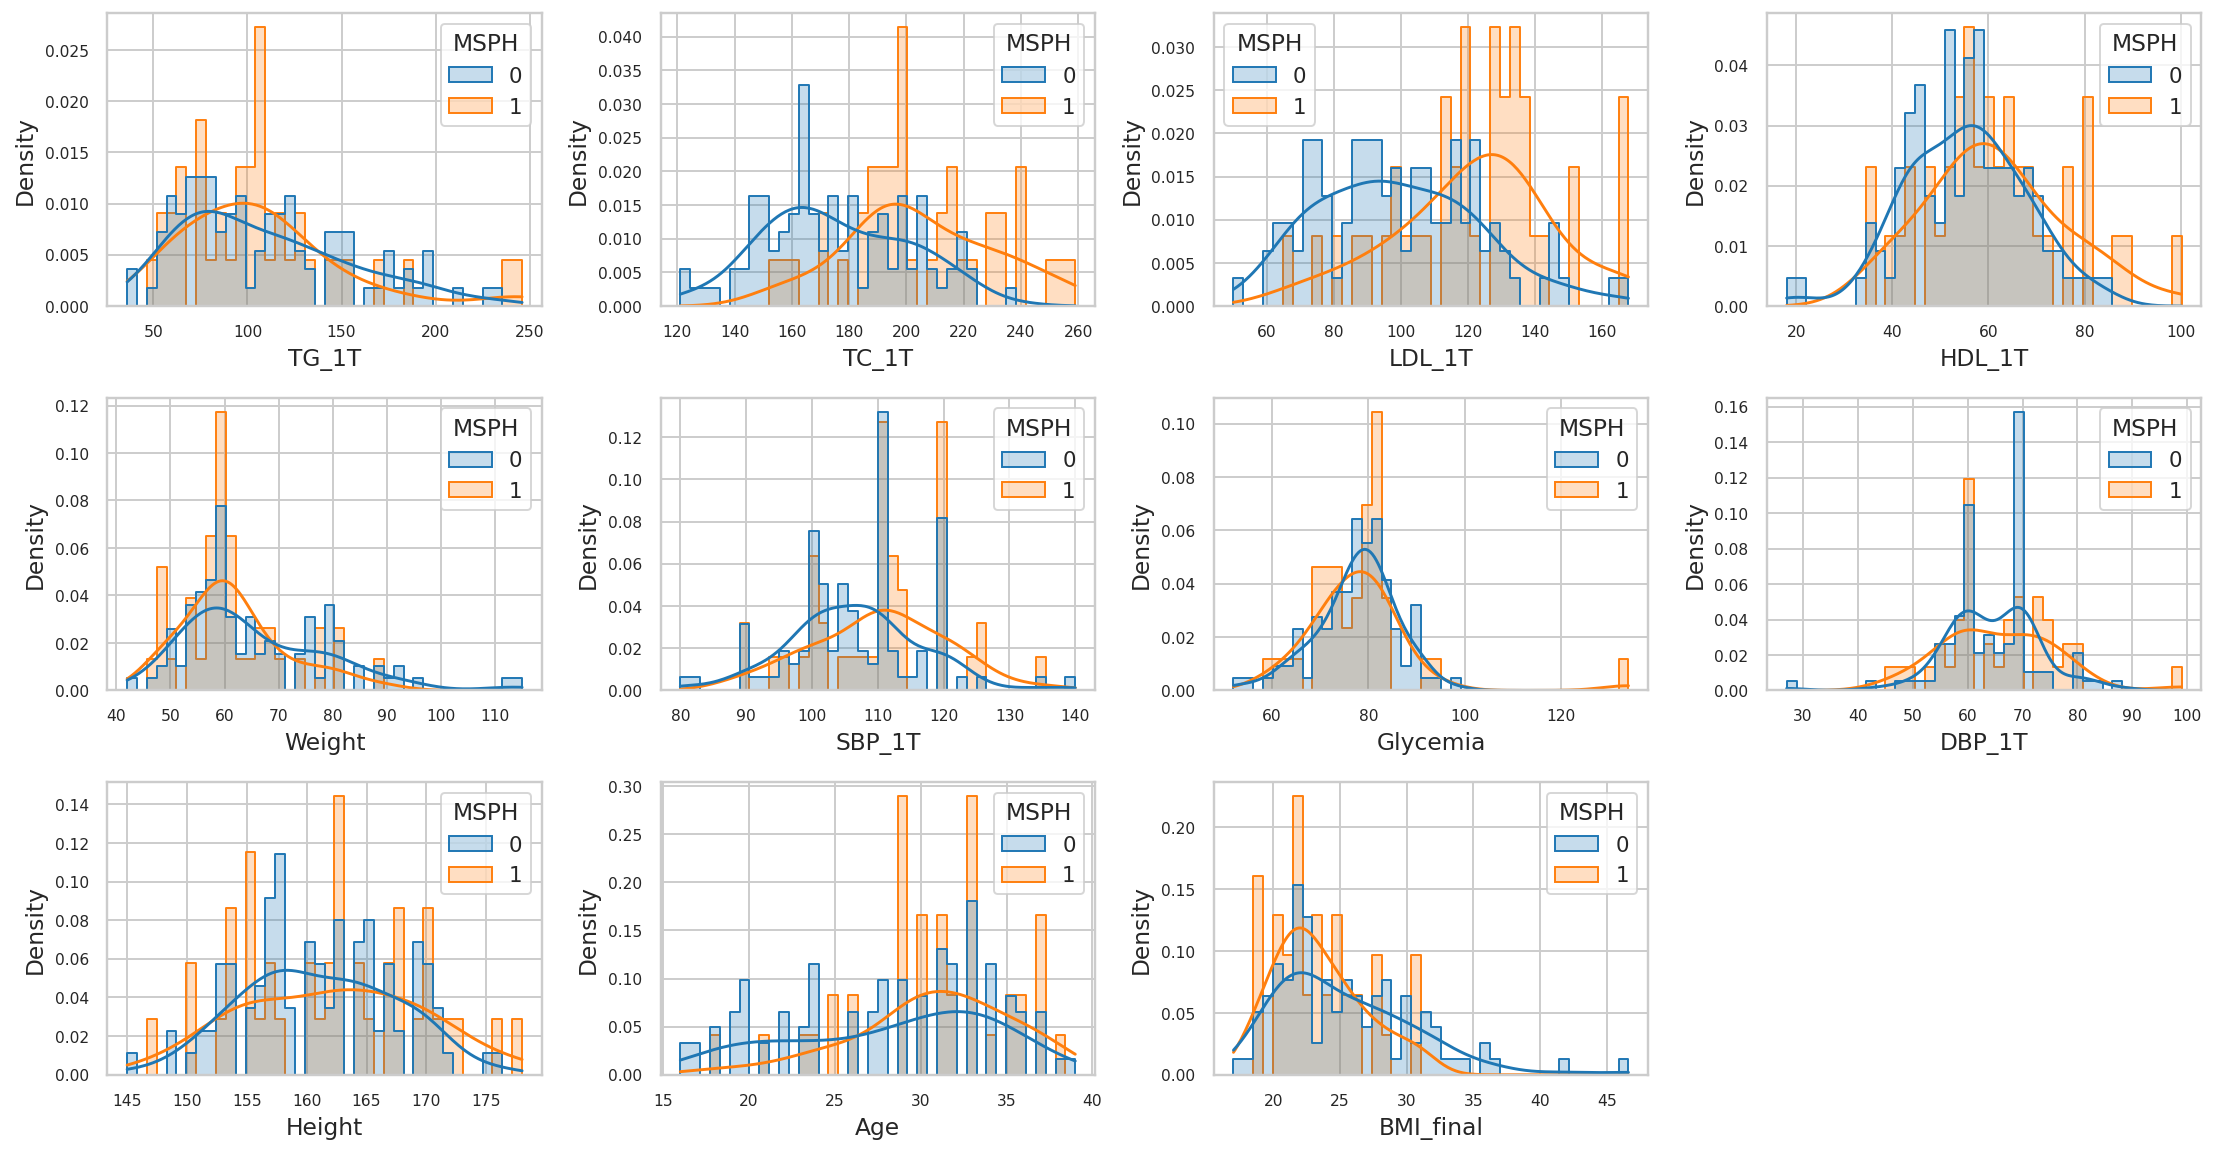

Saved: /home/david/Desktop/colabs/serra_ramon/hypercholesterolemia_classifiers/results/eda/figures/univariate/hist_by_label_strict_n11.png


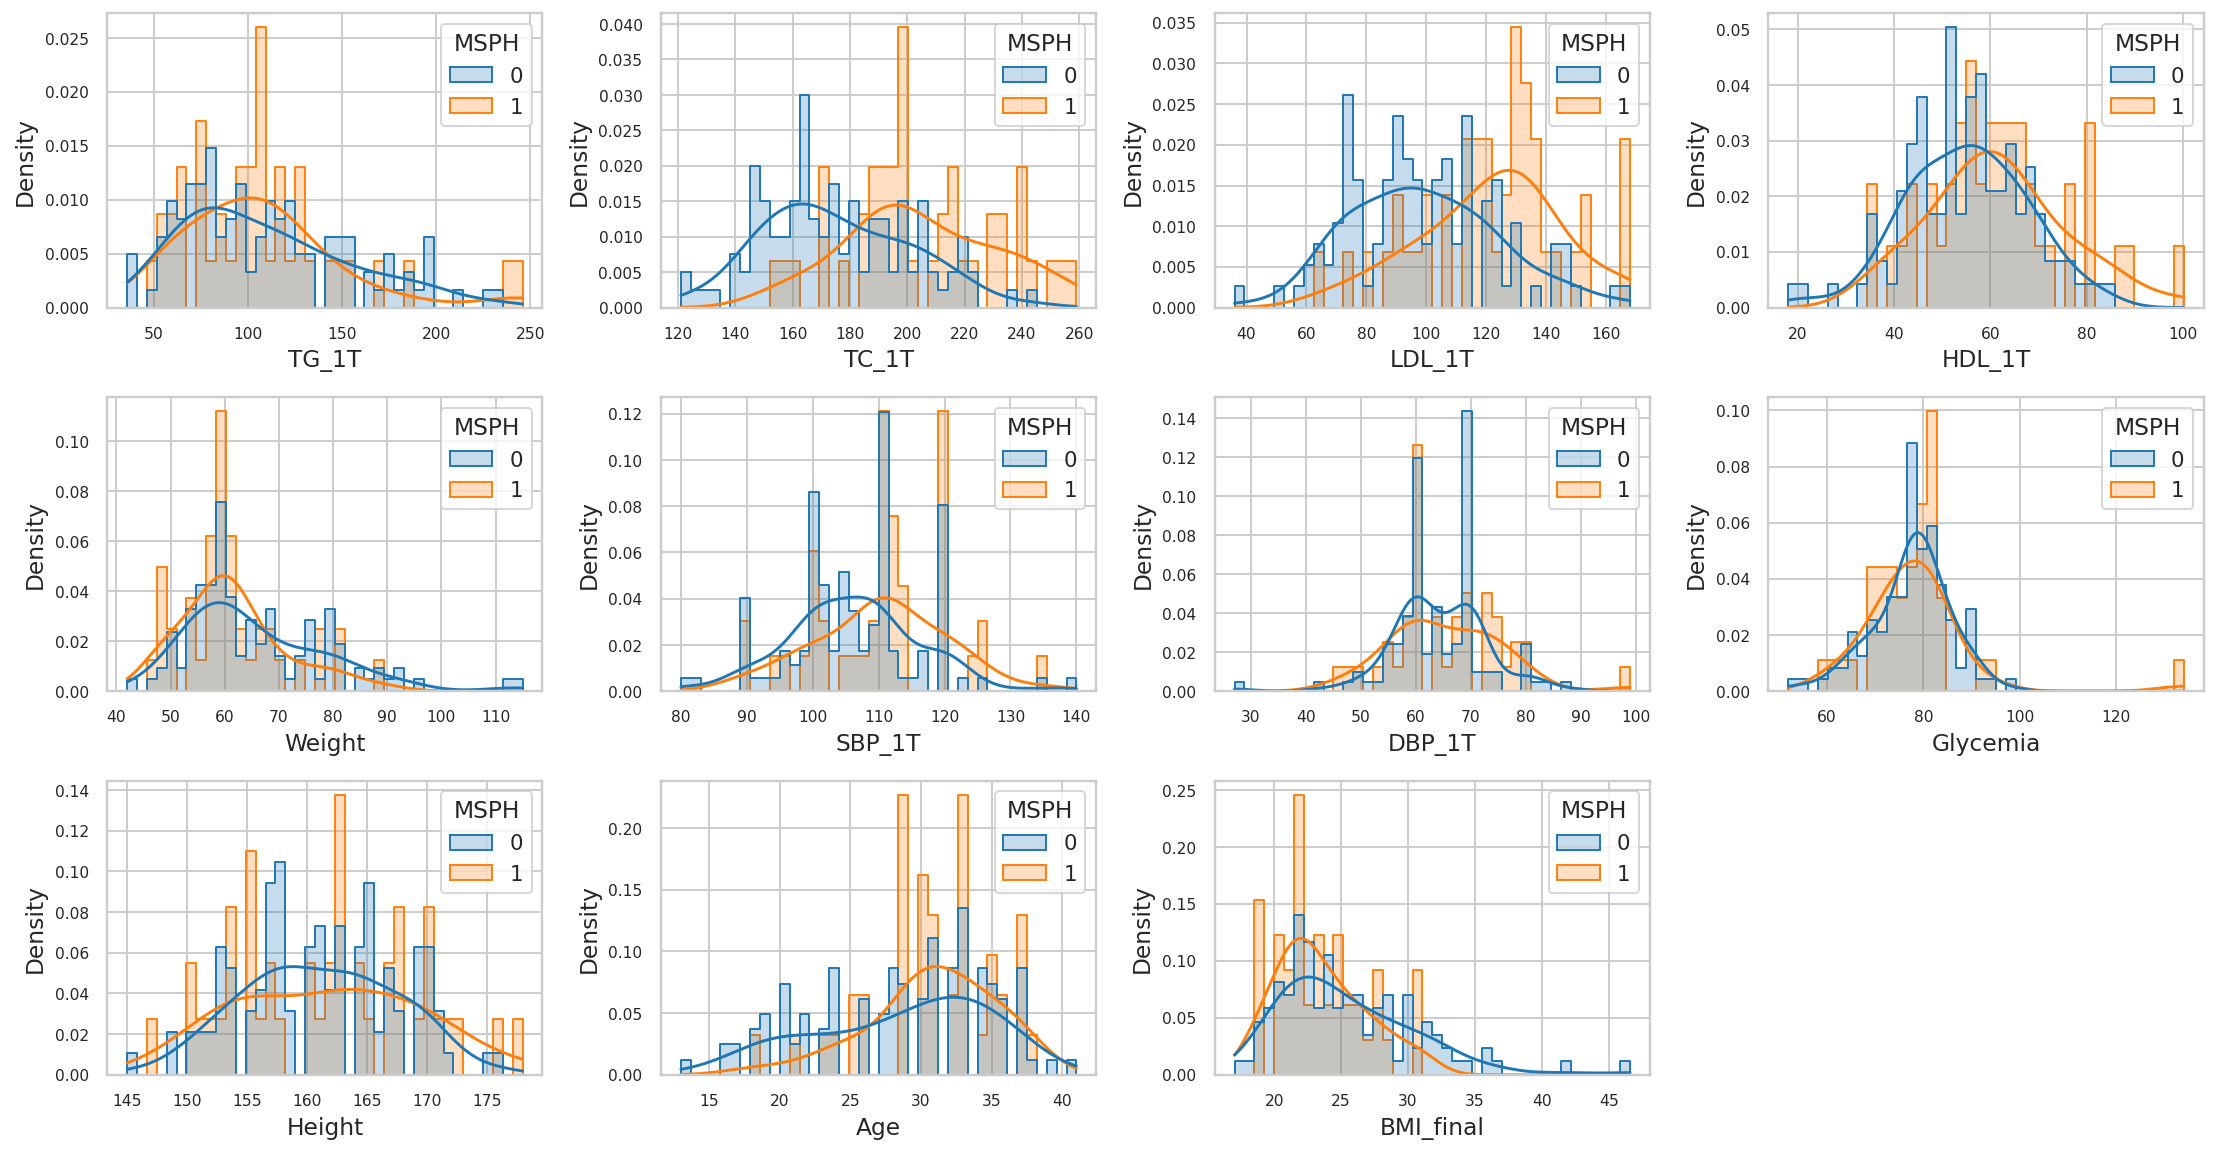

Saved: /home/david/Desktop/colabs/serra_ramon/hypercholesterolemia_classifiers/results/eda/figures/univariate/hist_by_label_imputed_n11.png


PosixPath('/home/david/Desktop/colabs/serra_ramon/hypercholesterolemia_classifiers/results/eda/figures/univariate/hist_by_label_imputed_n11.png')

In [28]:
def histplot_grid_by_label(
    df_eda: pd.DataFrame,
    label_col: str,
    features: List[str],
    dataset_name: str,
    bins: int = 5,
    ncols: int = 4,
) -> Optional[Path]:
    """
    Plot a grid of seaborn histograms for selected features, colored by label.

    Parameters
    ----------
    df_eda : pd.DataFrame
        Dataframe containing label + features.
    label_col : str
        Label column name.
    features : List[str]
        Feature names to plot.
    dataset_name : str
        Dataset identifier.
    bins : int
        Histogram bins.
    ncols : int
        Grid columns.

    Returns
    -------
    Optional[Path]
        Saved figure path if successful.
    """
    feats = [f for f in features if f in df_eda.columns]
    if not feats:
        print(f"[{dataset_name}] No features to plot.")
        return None

    n = len(feats)
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 2.8*nrows))
    axes = np.array(axes).reshape(-1)

    for ax, f in zip(axes, feats):
        sns.histplot(
            data=df_eda,
            x=f,
            hue=label_col,
            bins=bins,
            element="step",
            stat="density",
            common_norm=False,
            kde=True,
            ax=ax,
        )
        ax.tick_params(axis="both", labelsize=8)
        ax.legend_.set_title(label_col) if ax.get_legend() else None

    # turn off unused axes
    for ax in axes[len(feats):]:
        ax.axis("off")

    fig.tight_layout()

    out = FIG_DIR / f"hist_by_label_{dataset_name}_n{n}.png"
    fig.savefig(out)
    plt.show()
    print("Saved:", out)
    return out

histplot_grid_by_label(eda_strict, label_col_s, features_plot_strict, "strict", bins=40, ncols=4)
histplot_grid_by_label(eda_imputed, label_col_i, features_plot_imputed, "imputed", bins=40, ncols=4)


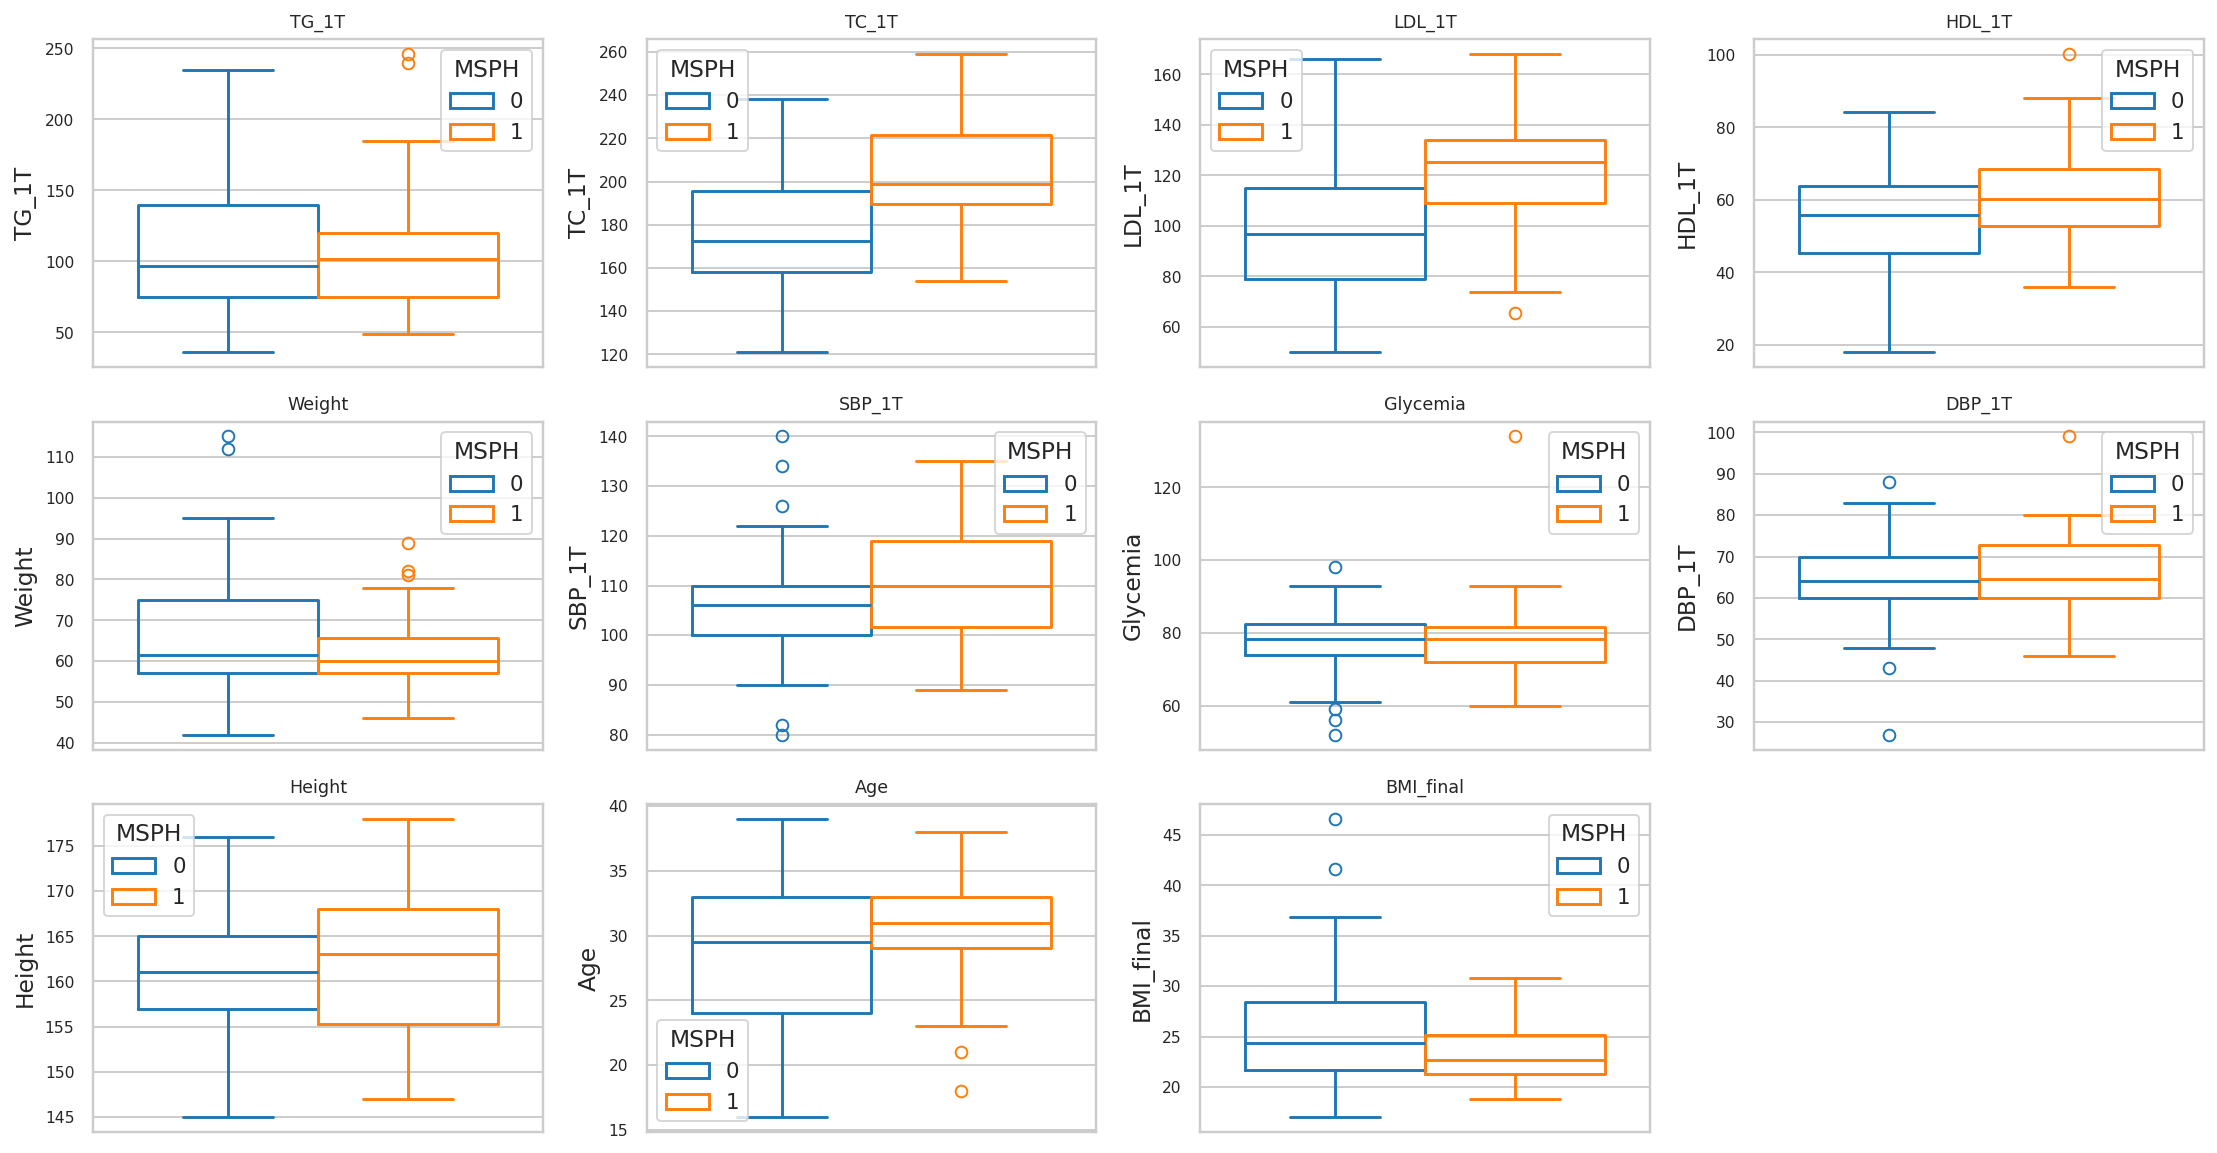

Saved: /home/david/Desktop/colabs/serra_ramon/hypercholesterolemia_classifiers/results/eda/figures/univariate/box_by_label_strict_n11_fliers1.png


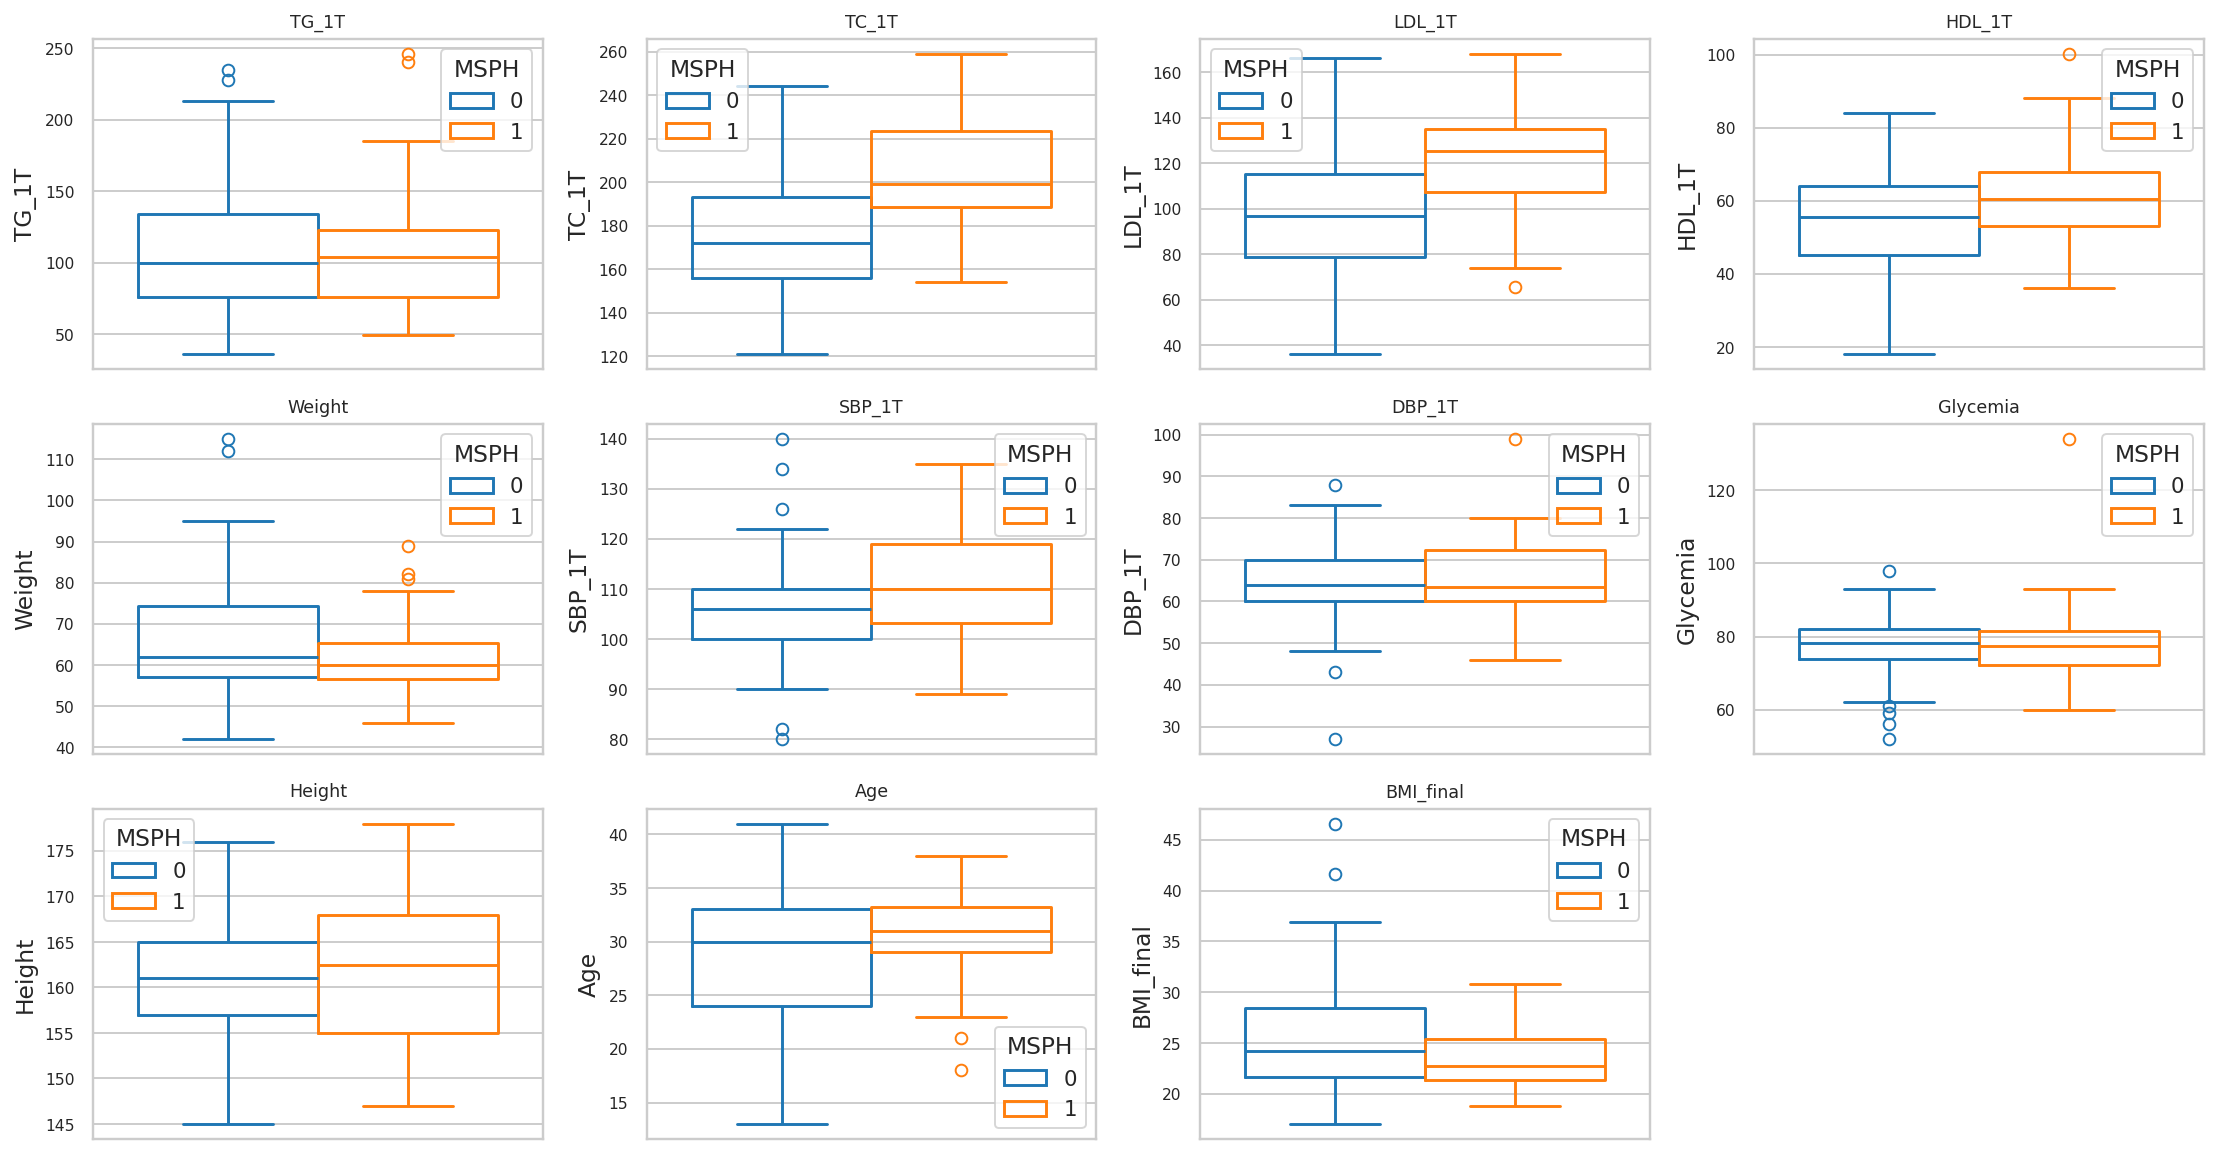

Saved: /home/david/Desktop/colabs/serra_ramon/hypercholesterolemia_classifiers/results/eda/figures/univariate/box_by_label_imputed_n11_fliers1.png


PosixPath('/home/david/Desktop/colabs/serra_ramon/hypercholesterolemia_classifiers/results/eda/figures/univariate/box_by_label_imputed_n11_fliers1.png')

In [29]:
def boxplot_grid_by_label(
    df_eda: pd.DataFrame,
    label_col: str,
    features: List[str],
    dataset_name: str,
    ncols: int = 4,
    showfliers: bool = True,
) -> Optional[Path]:
    """
    Plot a grid of seaborn boxplots for selected features by label.

    Parameters
    ----------
    df_eda : pd.DataFrame
        Dataframe containing label + features.
    label_col : str
        Label column name.
    features : List[str]
        Feature names to plot.
    dataset_name : str
        Dataset identifier.
    ncols : int
        Grid columns.
    showfliers : bool
        Whether to show outliers.

    Returns
    -------
    Optional[Path]
        Saved figure path if successful.
    """
    feats = [f for f in features if f in df_eda.columns]
    if not feats:
        print(f"[{dataset_name}] No features to plot.")
        return None

    n = len(feats)
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 2.8*nrows))
    axes = np.array(axes).reshape(-1)

    for ax, f in zip(axes, feats):
        sns.boxplot(
            data=df_eda,
            hue=label_col,
            y=f,
            fill=False,
            ax=ax,
            showfliers=showfliers,
            saturation=0.75
        )
        ax.set_title(f, fontsize=9)
        ax.tick_params(axis="both", labelsize=8)

    for ax in axes[len(feats):]:
        ax.axis("off")

    fig.tight_layout()

    out = FIG_DIR / f"box_by_label_{dataset_name}_n{n}_fliers{int(showfliers)}.png"
    fig.savefig(out)
    plt.show()
    print("Saved:", out)
    return out

boxplot_grid_by_label(eda_strict, label_col_s, features_plot_strict, "strict", ncols=4, showfliers=True)
boxplot_grid_by_label(eda_imputed, label_col_i, features_plot_imputed, "imputed", ncols=4, showfliers=True)


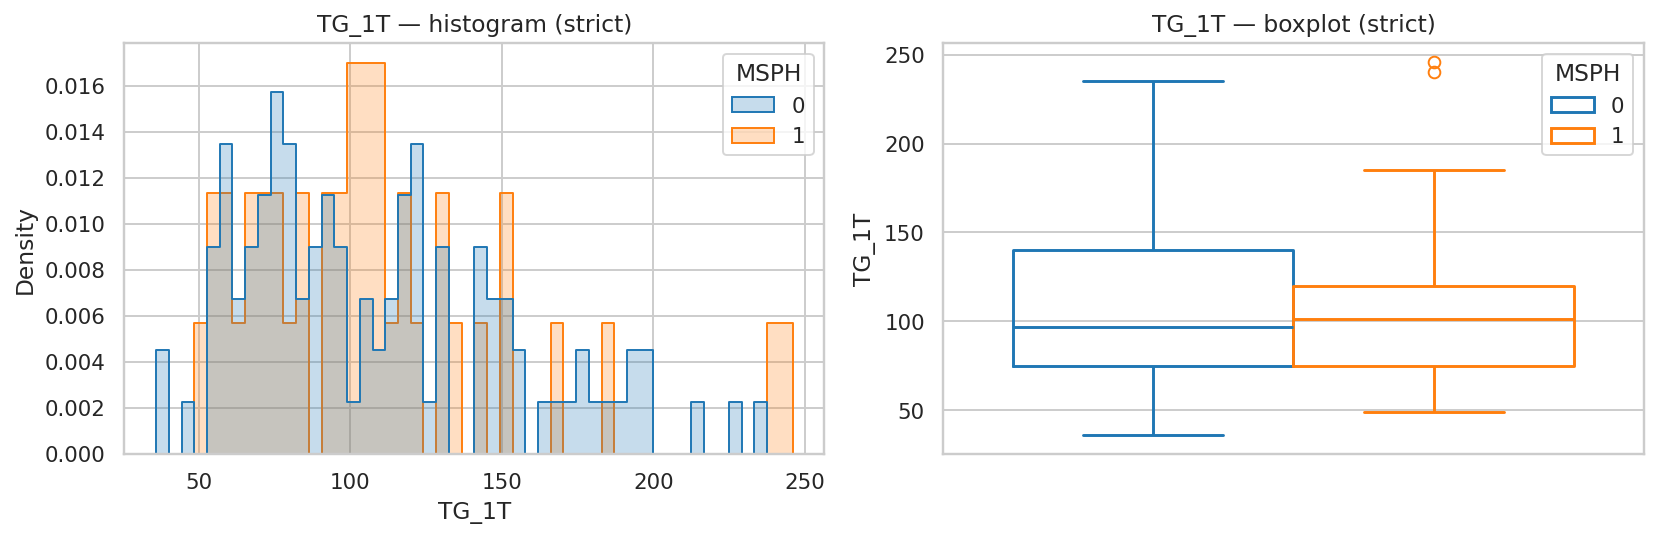

In [31]:
def plot_feature_deep_dive(
    df_eda: pd.DataFrame,
    label_col: str,
    feature: str,
    dataset_name: str,
    bins: int = 50,
) -> None:
    """
    Plot a focused set of plots for a single feature:
    - Histogram by label
    - Boxplot by label

    Parameters
    ----------
    df_eda : pd.DataFrame
        Dataframe with label + features.
    label_col : str
        Label column name.
    feature : str
        Feature to plot.
    dataset_name : str
        Dataset identifier.
    bins : int
        Histogram bins.
    """
    if feature not in df_eda.columns:
        raise ValueError(f"Feature '{feature}' not found.")

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(
        data=df_eda, x=feature, hue=label_col,
        bins=bins, element="step", stat="density",
        common_norm=False, ax=axes[0]
    )
    axes[0].set_title(f"{feature} — histogram ({dataset_name})")

    sns.boxplot(data=df_eda, fill=False, hue=label_col, y=feature, ax=axes[1], showfliers=True)
    axes[1].set_title(f"{feature} — boxplot ({dataset_name})")

    fig.tight_layout()
    plt.show()

# Example usage (uncomment and pick one feature)
plot_feature_deep_dive(eda_strict, label_col_s, features_plot_strict[0], "strict")


In [32]:
manifest = pd.DataFrame({
    "dataset": ["strict"] * len(features_plot_strict) + ["imputed"] * len(features_plot_imputed),
    "feature": features_plot_strict + features_plot_imputed,
    "rank_source": ["variance_topN"] * (len(features_plot_strict) + len(features_plot_imputed)),
})

manifest_path = STATS_DIR / "eda02_plotted_features_manifest.csv"
manifest.to_csv(manifest_path, index=False)
print("Saved:", manifest_path)
display(manifest.head(10))


Saved: /home/david/Desktop/colabs/serra_ramon/hypercholesterolemia_classifiers/results/eda/stats/eda02_plotted_features_manifest.csv


,dataset,feature,rank_source
0,strict,TG_1T,variance_topN
1,strict,TC_1T,variance_topN
2,strict,LDL_1T,variance_topN
3,strict,HDL_1T,variance_topN
4,strict,Weight,variance_topN
5,strict,SBP_1T,variance_topN
6,strict,Glycemia,variance_topN
7,strict,DBP_1T,variance_topN
8,strict,Height,variance_topN
9,strict,Age,variance_topN
